# AZURE DEPLOYEMNT PROCESS


In this project, we created a Notebook on Azure ML Services with a compute machine to build and run our model. And that instead of doing it from our local machine.

After training the model we deployed and got back an edpoint to use in other services like Flask

In [ ]:
# IMPORT SOME LIBS

In [46]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


## WORKSPACE CREATION OR INSTANTIATION

In [47]:
# import Azure SDK libraries


import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
    
import azureml
from azureml.core import Workspace
from azureml.core import Model
from azureml.core import Experiment
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage
from azureml.core.webservice import AciWebservice
from azureml.core.conda_dependencies import CondaDependencies

In [48]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Workspace name: airparadisopenclassroom
Azure region: eastus2
Subscription id: b7ff1da8-65bd-4db1-b5db-e88f05415e38
Resource group: kba-grp


## PREPARE THE MODEL FOR TRAINING

In [49]:
# MODEL TO TRAIN IN PY

import pandas as pd 
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import model_from_json

from tensorflow.keras.callbacks import Callback
from azureml.core import Dataset, Run

In [50]:
# LIBS

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import  EarlyStopping

import imageio
import os

In [104]:
# IMPORT MODEL AND UTILS FUNCTIONS
from utils_unet_model import *

from utils_funct_vgg import *


In [119]:
# SOME FUCNTIONS CREATED ALONG THE WAY 

def readDataImagesProd(image_list):
    target_size=(224, 224)
    img_list=[]
    for i in range(len(image_list)):
        img = imageio.imread(image_list[i])
        img = img[:,:, :3]                 # RETRIEVE the three first channels 
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, target_size )
        img_list.append(img)
        
    img_array= np.asarray(img_list)    

    return img_array


def read_raw_image_file(image_file):
    target_size=(224, 224)
    
    img = imageio.imread(image_file)
    img = img[:,:, :3]                 # RETRIEVE the three first channels 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_size )  
    img_array= np.asarray(img)    

    return img_array

In [105]:
# GET LIST OF IMAGE FILES  FROM DIRECTORIES
val_image_list, val_mask_list = getFilesPathsList(main_path, val_path_image, val_path_mask )

test_image_list , test_mask_list  = getFilesPathsList(main_path, test_path_image, test_path_mask)

train_image_list, train_mask_list  = getFilesPathsList(main_path, train_path_image, train_path_mask )

# add 1025 images files list to the train set from test sets
train_image_list , test_image_list  = train_image_list + test_image_list[:1025] , test_image_list[1025:]
train_mask_list , test_mask_list  = train_mask_list + test_mask_list[:1025] , test_mask_list[1025:]


In [ ]:
# GET DATA PREDICT API

In [106]:
val_image, val_mask = readDataImages(val_image_list[:3], 
                             val_mask_list[:3])


In [145]:
val_image_list[:3]

['./gtFine/val_images/frankfurt_000000_000294_gtFine_color.png',
 './gtFine/val_images/frankfurt_000000_000576_gtFine_color.png',
 './gtFine/val_images/frankfurt_000000_001016_gtFine_color.png']

In [139]:
import os
os.path.basename
for i in val_image_list[:3]:
    print(os.path.basename(i).split('.')[0])

frankfurt_000000_000294_gtFine_color
frankfurt_000000_000576_gtFine_color
frankfurt_000000_001016_gtFine_color


In [181]:
img_id=[os.path.basename(x).split('.')[0]  for x  in sorted(val_image_list[:3])]

def get_img_path_file(img_id):
    """
    could change the path_root to be transportable folder
    containing the images
    """
    path_root='./gtFine/val_images/'
    return path_root+img_id+'.png'


def read_raw_image_file(image_file):
    
    target_size=(224, 224)
    
    img = imageio.imread(image_file)
    img = img[:,:, :3]                 # RETRIEVE the three first channels 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_size )  
    img_array= np.asarray(img)    

    return img_array
    

img_array=read_raw_image_file(get_img_path_file(img_id[2]))

print(img_array.shape)
# convert to tensor and add a dim
sample_img=tf.constant(img_array)[tf.newaxis, ...]
print(sample_img.shape)

In [182]:
get_img_path_file(img_id[0])

'./gtFine/val_images/frankfurt_000000_000294_gtFine_color.png'

In [174]:
!ls './gtFine/val_images/frankfurt_000000_000294_gtFine_color.png'

./gtFine/val_images/frankfurt_000000_000294_gtFine_color.png


In [183]:
# read img_path_file
img_ray= read_raw_image_file(get_img_path_file(img_id[0]))

In [184]:
img_ray.shape

(224, 224, 3)

In [185]:
img_array=read_raw_image_file(get_img_path_file(img_id[2]))

In [186]:
print(img_ray.shape)
# convert to tensor and add a dim
sample_img=tf.constant(img_array)[tf.newaxis, ...]
print(sample_img.shape)

(224, 224, 3)
(1, 224, 224, 3)


In [116]:
val_image1=readDataImagesProd(val_image_list[:3])

In [120]:
val_data_image= tf.data.Dataset.from_tensor_slices(val_image1)

In [122]:
for i in val_data_image.batch(1):
    print(i.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)
(1, 224, 224, 3)


In [125]:
tf.constant(val_image1[0])[tf.newaxis, ...].shape

TensorShape([1, 224, 224, 3])

In [109]:
val_image, val_mask = stackDataSets(val_image, val_mask)

In [110]:
val_data_unet= tf.data.Dataset.from_tensor_slices((val_image, val_mask))

In [111]:
for i, j in val_data_unet.take(1):
    print(i.shape, j.shape)

(224, 224, 3) (224, 224, 1)


In [ ]:
# END GET DATA PREDICT API

In [10]:
# READ FROM RAW
val_image, val_mask = readDataImages(val_image_list, 
                             val_mask_list)

test_image, test_mask = readDataImages(test_image_list, 
                             test_mask_list)

train_image, train_mask = readDataImages(train_image_list, 
                             train_mask_list)

In [11]:
# SEG GEN
val_image, val_mask = stackDataSets(val_image, val_mask)

train_image, train_mask= stackDataSets(train_image, train_mask)

In [11]:
# AUGMENT AND MERGE 
# I usually off it for testing 
# A good way double up the data
# I used ALBUMENTION 
# And USE ROTATTION AND HORIZONTAL_FLIP
val_image, val_mask = augConcat(val_image.numpy(), val_mask.numpy()) 

train_image, train_mask = augConcat(train_image.numpy(), train_mask.numpy() ) 


In [12]:
# create TF Datasets

val_data_unet= tf.data.Dataset.from_tensor_slices((val_image, val_mask))


test_data_unet= tf.data.Dataset.from_tensor_slices((test_image, test_mask))


train_data_unet=tf.data.Dataset.from_tensor_slices((train_image, train_mask))



In [13]:
for i, j in val_data_unet.take(1):
    print(i.shape)
len(list(val_data_unet)), len(list(train_data_unet))

(224, 224, 3)


(500, 4000)

# TRAINING
I changed the batch size to one for inference constraint.
I was getting an error with the query after return. And instead increasing the service workload, I just decreased the batch size. The performance didn't change so...


In [ ]:
# model
img_height = 224
img_width = 224
num_channels = 3

unet = unet_model((img_height, img_width, num_channels), n_classes=8)

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [108]:
# TRAINING

EPOCHS = 20
VAL_SUBSPLITS = 5
BUFFER_SIZE = 250
BATCH_SIZE = 1

steps_per_epoch=20
validation_steps=20


#train_data_unet1 = train_data_unet.batch(BATCH_SIZE)
#val_data_unet1 = val_data_unet.batch(BATCH_SIZE)

train_data_unet1 = train_data_unet.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_data_unet1 = val_data_unet.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



print(train_data_unet1.element_spec)

print(len(list(train_data_unet1)))

model_history = unet.fit(train_data_unet1, 
          epochs=EPOCHS, 
          validation_data=val_data_unet1, 
          steps_per_epoch=steps_per_epoch, 
          validation_steps=validation_steps,
          verbose=2,
          callbacks=[EarlyStopping(
              patience=7,
              min_delta=0.05,
              baseline=0.8,
              mode='min',
              monitor='val_loss',
              restore_best_weights=True,
              verbose=1)
          ])

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float64, name=None))
4000
Epoch 1/20
20/20 - 3s - loss: 0.0947 - accuracy: 0.9711 - val_loss: 0.1137 - val_accuracy: 0.9635 - 3s/epoch - 145ms/step
Epoch 2/20
20/20 - 2s - loss: 0.0626 - accuracy: 0.9809 - val_loss: 0.0960 - val_accuracy: 0.9702 - 2s/epoch - 121ms/step
Epoch 3/20
20/20 - 2s - loss: 0.0891 - accuracy: 0.9739 - val_loss: 0.1049 - val_accuracy: 0.9678 - 2s/epoch - 119ms/step
Epoch 4/20
Restoring model weights from the end of the best epoch: 1.
20/20 - 2s - loss: 0.0648 - accuracy: 0.9798 - val_loss: 0.0743 - val_accuracy: 0.9757 - 2s/epoch - 122ms/step
Epoch 00004: early stopping


In [19]:
def show_predictions_unet(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

In [112]:
# AZURE LOCAL PREDICTION
for image, mask in val_data_unet1.take(1):
    sample_image, sample_mask = image[0], mask[0]
    print(image.shape, mask.shape)
    print(sample_image.shape)
    #print(sample_mask.shape)
#pred_mask = unet.predict(sample_image[tf.newaxis, ...])
#display([sample_image, sample_mask])

(1, 224, 224, 3) (1, 224, 224, 1)
(224, 224, 3)


In [114]:
pred_mask = unet.predict(sample_image[tf.newaxis, ...])

In [116]:
pred_mask.shape

(1, 224, 224, 8)

In [128]:
sample_im=tf.constant(val_image1[0])[tf.newaxis, ...]

In [130]:
#pred_mask_test = unet.predict(sample_im)

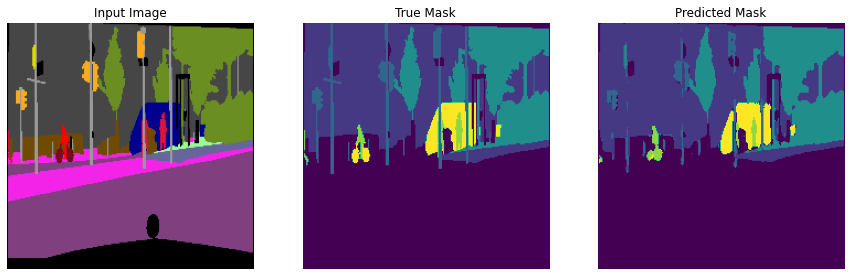

In [111]:
show_predictions_unet(val_data_unet1, 1)

# PREPARE FOR DEPLOYMENT

In [22]:
# SAVE THE MODEL

os.makedirs('./outputs/model', exist_ok=True)

# serialize DNN architecture to JSON
model_json = unet.to_json()
# save model JSON
with open('./outputs/model/model.json', 'w') as f:
    f.write(model_json)
# save model weights
unet.save_weights('./outputs/model/model.h5')
print("model saved in ./outputs/model folder")

model saved in ./outputs/model folder


Many aspect of tyhe model deployement to consider. it is to folllow those steps or at least have some requirement or consideration for a model to be deplyed successfully on Azure :

1- **Create an Experiment**: this is the entry point for any Azure ML model training and deployment. And in the Experiment, we are going to register our work, the Model.

2- **Model Register**: smart and intuitive design. It is to say we can have many experiments in training and testing and only register one model or some models. Not all experiments are good to be considered or to be learned from. In general we choose to forget some bad experiences right? lol. And then when a model is registered, we are allowed to deploy it, to put itin use. 

3- **Deployment**: the model can then be deployed as service. A stand alone running app. Therefore, it needs to be encapsulated in such a way that it has everything it needs to run. In this process Azure propose us to use its ACI or AKS services to create image containers with Kubernetes or Docker. Here we use docker to create an instance contaner from a docker image.

At the end after deployement, we have a URI to ready to be used outside Azure in other service like Flask.


In [12]:
import os
from azureml.core import Experiment
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# CREATE AN EXPERIMENT

# instantiate the experiment, the entry point for the Azure ML
exp = Experiment(workspace=ws, name='compute_paradis')

In [21]:
# created but not used, since I decide to train manually and not through scripting
script_folder = './air_paradis'
os.makedirs(script_folder, exist_ok=True)

In [19]:
# reuse the fat compute servce that you created from the start 
compute_target = ComputeTarget(workspace=ws, name='computeparadis')

In [20]:
compute_target

Name,Workspace,State,Location,VmSize,Application URI,SSH,Docs
computeparadis,airparadisopenclassroom,Running,eastus2,STANDARD_NC6,Jupyter JupyterLab RStudio,azureuser@20.94.97.98 -p 50001,Doc


In [178]:
# always check the workspace
print(ws)

Workspace.create(name='airparadisopenclassroom', subscription_id='b7ff1da8-65bd-4db1-b5db-e88f05415e38', resource_group='kba-grp')


In [32]:
# REGISTER THE MODEL
from azureml.core import Model
model_unet_regist = Model.register(workspace=ws,
                       model_name='air_paradis',
                       model_path='outputs/model', # local path
                       description='Image segementation model')

Registering model air_paradis


In [28]:
%%writefile score.py # comment out if you feel like overwritting the inference file
import os
import json
import numpy as np
import pandas as pd

from azureml.core.model import Model
#from keras.models import model_from_json
import tensorflow
from tensorflow.keras.models import model_from_json


def init():
    global model
    # model_root is to ref the model and then take the path from there
    # the real path for local test is "./outpust/model"
    model_root = Model.get_model_path('air_paradis')
    json_file = open(os.path.join(model_root, 'model.json'), 'r')
    model_json = json_file.read()
    json_file.close()
    # deserialize the model using keras lib model_from_json
    model = model_from_json(model_json)
    print(model)
    # load weights into new model
    model.load_weights(os.path.join(model_root, "model.h5"))
    model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])   

    #print("The model from json : ", model)
 
    
def run(raw_data):
    data= np.array(json.loads(raw_data)['data'])
    
    y_hat=model.predict(data)
    return json.dumps(y_hat.tolist())


UsageError: unrecognized arguments: # comment out if you feel like overwritting the inference file


# DEPLOY THE MODEL 

In [97]:
# DEPLOY THE MODEL 
# # create config for the infernce file
## configure an ACI an image to serve the model
## and give that all to the service

from azureml.core.webservice import AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.model import Model

inference_config = InferenceConfig(entry_script="score.py", environment=keras_env)

aciconfig = AciWebservice.deploy_configuration(cpu_cores=2,
                                               auth_enabled=True, # this flag generates API keys to secure access
                                               memory_gb=2,
                                               tags={'name': 'air_paradis_container', 'framework': 'Keras'},
                                               description='image segmentation')

service = Model.deploy(workspace=ws, 
                           name='airparadisservice', 
                           models=[model_unet_regist], 
                           inference_config=inference_config, 
                           deployment_config=aciconfig)

service.wait_for_deployment(True)
print(service.state)
# if things go wrong !!!!!
#print(service.get_logs())
print(service.scoring_uri)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-12-13 19:02:09+00:00 Creating Container Registry if not exists.
2021-12-13 19:02:09+00:00 Registering the environment.
2021-12-13 19:02:10+00:00 Use the existing image.
2021-12-13 19:02:10+00:00 Generating deployment configuration.
2021-12-13 19:02:11+00:00 Submitting deployment to compute.
2021-12-13 19:02:15+00:00 Checking the status of deployment airparadisservice..
2021-12-13 19:05:44+00:00 Checking the status of inference endpoint airparadisservice.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy
http://4086ed70-8ad9-4c25-9f18-1a821627531d.eastus2.azurecontainer.io/score


In [98]:
# TESTING THE URI USING SERVICE.RUN

# prepare the input in Json
input_samples = json.dumps({"data": sample_image.numpy().tolist()})
input_samples = bytes(input_samples, encoding='utf8')

In [ ]:
# unit test in local using init and run from the score.py file
#pred_json=run(input_samples)

In [127]:
# do the prediction by using teh run method directly from the inference script
pred=service.run(input_samples)

In [163]:
# get the content of a string
import ast
pred1 = ast.literal_eval(pred)
print(len(pred1[0][0][0]))

In [169]:
# convert the pred to tensor
pred3=tf.constant(pred1)

In [171]:
pred_mask1= np.argmax(pred3, axis=3)

In [149]:
pred_mask1 = tf.constant(pred_mask1)

In [176]:
sample_image.shape,  pred_mask1[...,tf.newaxis][0].shape

(TensorShape([224, 224, 3]), (224, 224, 1))

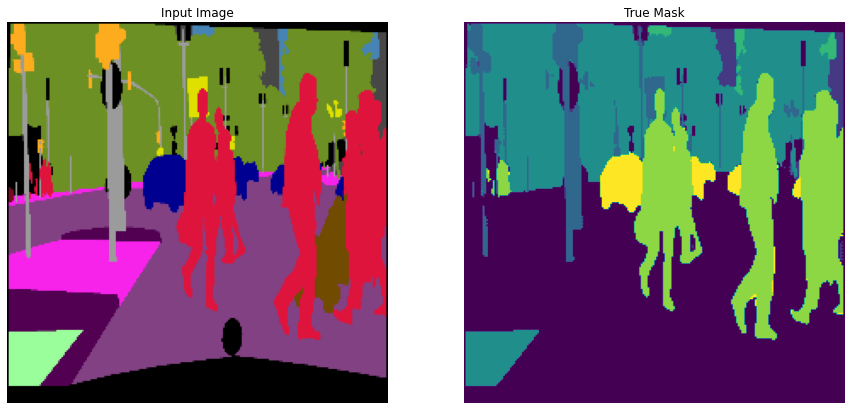

In [175]:
display([sample_image, pred_mask1[...,tf.newaxis][0]])

# PREPARE INPUT TRANSFORMATION AND FLASK LOCAL BUILD 

From now the model is already deployed on Asure and the URI got tested and is working well.
Above we just give an input to the URI for scoring and it worked. Now let's build a tiny pipeline for Flask and other service web application. 

It is to go from a raw image and predict an annoatated image. The raw image got transformed along the way.


In [8]:
# FLASK LOCAL BUILD AND TEST

In [103]:
# LIST OF NEEDED LIBS FOr FLASK
import urllib.request
import json
import os
import ssl
import pandas as pd
import numpy as np
import matplotlib
import tensorflow as tf
import keras
import imageio


In [247]:
# get this image for the index html

In [308]:
url = 'http://4086ed70-8ad9-4c25-9f18-1a821627531d.eastus2.azurecontainer.io/score'
api_key = 'EylgUu1MzEW2AboZEUxFjcWeNDqYwToF' # Replace this with the API key for the web service
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}


import urllib.request
import json
import os
import ssl

def allowSelfSignedHttps(allowed):
    # bypass the server certificate verification on client side
    if allowed and not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl,
                                                                           '_create_unverified_context', None):
        ssl._create_default_https_context = ssl._create_unverified_context

allowSelfSignedHttps(True) # this line is needed if you use self-signed certificate in your scoring service.

#img_id=[os.path.basename(x).split('.')[0]  for x  in sorted(val_image_list[:3])]

def get_img_path_file(img_id):
    """
    could change the path_root to be transportable folder
    containing the images
    """
    img_id=str(img_id)
    path_root='./static/images/'
    return path_root+img_id+'.png'


def read_raw_image_file(image_file):
    
    target_size=(224, 224)
    
    img = imageio.imread(image_file)
    img = img[:,:, :3]                 # RETRIEVE the three first channels 
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, target_size )  
    img_array= np.asarray(img)    

    return img_array
    


def prediction_call_service(image_id):
    
    img_array=read_raw_image_file(get_img_path_file(image_id))
    
    # convert to tensor and add a dim
    sample_image=tf.constant(img_array)[tf.newaxis, ...]
    
    data= {"data": sample_image.numpy().tolist()}
    
    body = str.encode(json.dumps(data))
    
    req = urllib.request.Request(url, body, headers)
    
    try:
        response = urllib.request.urlopen(req)
    
        result = response.read()
        pred = ast.literal_eval(ast.literal_eval(result.decode("utf-8")))
        pred_mask = np.argmax(tf.constant(pred), axis=3)[..., tf.newaxis]
        
        #print("Input Image and Predicted Mask")

        display_list=[sample_image[0], pred_mask[0]]
        
        fig = plt.figure(figsize=(15, 15))

        title = ['Input Image', 'Predicted Mask']
        

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')
        plt.savefig('./static/images/image_pred.png') # saved here
        plt.close()
        return fig
    

        #display_prod([sample_image[0], pred_mask[0]]) # save an image somewhere

        #print(result)
    except urllib.error.HTTPError as error:
        print("The request failed with status code: " + str(error.code))
    
        # Print the headers - they include the requert ID and the timestamp, 
        # which are useful for debugging the failure
        print(error.info())
        print(json.loads(error.read().decode("utf8", 'ignore')))


#figz=prediction_call_service('frankfurt_000000_000294_gtFine_color')

In [279]:
!ls ./static/images/

image_pred.png to.png
